# Using Fractional Cover (FC) to train a Random Forest (RF) Classifier for Land-cover Classification

The goal in this notebook is to train a classifier at the regional scale (Pacific) to get land-cover classification. The Pacific Islands face a critical lack of locally accurate land cover datasets. Existing global products are designed for continental or global scales and often fail to capture the nuanced land cover dynamics of the Pacific region. This leads to misclassification, underrepresentation of smaller land cover types, and unreliable data for local decision-making. The goal of our Random Forest classifier trained on fractional cover data and spectral data is to addresse this gap by providing a regionally tuned, high resolution land cover product specifically trained on Pacific island environments (e.g., Fiji, Cook Islands, Marshall Islands). 

In [12]:
import pandas as pd
import numpy as np 
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rasterio
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

## 1. Data Preparation 

Data from Fiji, Cook Island, Marshall Island and Palaos were download to train a random forest that return land cover classification over the pacific region. We have for each island a shapefile containing point with the associated grountruth land cover label and position (lat, lon) and from the Sentinel-2 geomad, the RGB-NIR band were downloaded to compute the NDVI and NDWI and finally with .tif file with 3 bands for the annual fractionnal cover over each island. Then, we prepare the data using QGIS to have one dataset (shapefile) for each island containing for each point the following data :

- lat, lon
- Fractional Cover (bs : baresoil ; pv : photosynthetic vegetation ; npv : non-photosynthetic vegetation)
- NDVI
- NDWI
- NDBI (Normalized Difference Build Index)
- RGB-NIR (spectral bands)
- Label (class-id : 1. Forest ; 2. Cropland ; 3. Grassland ; 4. Buildup ; 5. Baresoil ; 6. Water ; 7. Mangroves)
- lulc (land-use, land-cover)
- Texture data (10 bands computed using Haralick Extraction Feature in QGIS --> GLCM)

The data are in the folder data, there 4 files (one per island).

In [13]:
# dataset path + loading

fiji_path = "./data/fiji.xlsx"
marshall_path = "./data/marshall.xlsx"
cook_path = "./data/cook.xlsx"
palaos_path = "./data/palaos.xlsx"

fj = pd.read_excel(fiji_path)
mh =  pd.read_excel(marshall_path)
ck =  pd.read_excel(cook_path)
pl =  pd.read_excel(palaos_path)

fj.head()

,fid,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,ndvi1,ndwi1,...,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10
0,1,1,forest,9,0,87,178.325,-17.535,0.884564,-0.775417,...,4.84,0.1344,0,9.68,0.2976,1.021119,0.667973,0.1056,-0.868332,0.730750
1,2,1,forest,5,8,94,178.300,-17.535,0.823159,-0.711232,...,4.00,0.0000,0,8.00,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
2,3,2,cropland,7,20,76,177.511,-17.551,0.804638,-0.734354,...,4.04,0.0384,0,8.08,0.0736,0.402179,0.296425,0.0384,-0.871069,0.503652
3,4,1,forest,2,10,89,177.651,-17.550,0.838690,-0.754122,...,4.08,0.0736,0,8.16,0.1344,0.634310,0.502801,0.0736,-0.849343,0.614172
4,5,2,cropland,8,31,60,177.664,-17.550,0.583125,-0.570485,...,3.98,0.0196,0,7.68,2.4576,0.056538,0.169415,0.0196,-0.879383,0.397971


In [14]:
def add_mean_std_per_lulc(df):
    group_stats = (
        df.groupby(['lulc'])['ndvi1']
        .agg(ndvi_mean='mean', ndvi_std='std')
        .reset_index()
    )
    
    df = df.merge(group_stats, on=['lulc'], how='left')
    return df 


fj = add_mean_std_per_lulc(fj)
mh = add_mean_std_per_lulc(mh)
ck = add_mean_std_per_lulc(ck)
pl = add_mean_std_per_lulc(pl)

In [15]:
# Create a table summarizing the lulc category distribution 

def count_lulc(df, island_name):
    counts = df["lulc"].value_counts().to_frame(name=island_name).T
    return counts

fj_counts = count_lulc(fj, "Fiji")
mh_counts = count_lulc(mh, "Marshall")
ck_counts = count_lulc(ck, "Cook")
pl_counts = count_lulc(pl, "Palaos")

summary = pd.concat([fj_counts, mh_counts, ck_counts, pl_counts], axis=0).fillna(0).astype(int)
summary["Total"] = summary.sum(axis=1)
summary = summary.sort_values(by="Total", ascending=False)

summary.head()

lulc,forest,grassland,mangroves,cropland,buildup,water,baresoil,Total
Fiji,3267,1520,683,558,137,39,15,6219
Cook,103,59,0,80,113,55,181,591
Palaos,72,77,18,63,42,36,183,491
Marshall,142,22,6,4,47,25,55,301


This summary table shows that there are a lot of data point in Fidji (on average 10 times more than in the other island) and that forest label is also over-represented. If we train a classifier directly on all the data, it will learn only charactheristics from this class and location and thus the classifier will be very bad on other class or other location. To avoid this, we need to balance the dataset before training the classifier.

### Deal with imbalance dataset

To build a good classifier that generalizes well across the Pacific, balancing data is important :

- Balancing between classes (so each LULC type is equally learned)
- Balancing between locations (so it doesn't overfit to any specific island)

But a minimum amount of data is needed in order to have a good classifier. Regarging the previous table, the less represented classes are water (155) and buildup (339). Based on this, the objective is to keep aroun 150-300 points per lulc. Finally to preserve spatial generalization, points from each island should be equally reprensented in each class.

I set manually : 

- Forest : Fiji : 80 ; Cook : 75 ; Palaos : 70 ; Marshall : 75 = 300
- Grassland : Fiji : 150 ; Cook : 59 ; Palaos : 77 ; Marshall : 22 = 308
- Mangroves : Fiji : 180 ; Cook : 0 ; Palaos : 18 ; Marshall : 6 = 204
- Cropland : Fiji : 150 ; Cook : 80 ; Palaos : 63 ; Marshall : 4 = 300
- Buildup : Fiji : 110 ; Cook : 110 ; Palaos : 40 ; Marshall : 40 = 300
- Water : Fiji : 39 ; Cook : 55 ; Palaos : 36 ; Marshall : 25 = 155
- Baresoil : Fiji : 15 ; Cook : 115 ; Palaos : 115 ; Marshall : 55 = 300

Following this distribution, the RF would be trained on 1867 data points.

In [53]:
random.seed(42)

sampling_plan = {
    "forest":     {"Fiji": 80,  "Cook": 75,  "Palaos": 70,  "Marshall": 75},
    "grassland":  {"Fiji": 140, "Cook": 59,  "Palaos": 77,  "Marshall": 22},
    "mangroves":  {"Fiji": 180, "Cook": 0,   "Palaos": 18,  "Marshall": 6},
    "cropland":   {"Fiji": 155, "Cook": 80,  "Palaos": 63,  "Marshall": 4},
    "buildup":    {"Fiji": 110, "Cook": 110, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 39,  "Cook": 55,  "Palaos": 36,  "Marshall": 25},
    "baresoil":   {"Fiji": 15,  "Cook": 115, "Palaos": 115, "Marshall": 55}
}

island_dfs = {
    "Fiji": fj,
    "Cook": ck,
    "Palaos": pl,
    "Marshall": mh
}


samples = []


for lulc_class, island_counts in sampling_plan.items():
    for island, n_points in island_counts.items():
        if n_points == 0:
            continue
        df = island_dfs[island]
        df_filtered = df[df["lulc"] == lulc_class]

        if len(df_filtered) < n_points:
            raise ValueError(f"Not enough data for {lulc_class} in {island} (needed {n_points}, available {len(df_filtered)})")

        # Convert to list of rows (dicts), sample with random
        filtered_list = df_filtered.to_dict(orient="records")
        selected = random.sample(filtered_list, n_points)

        # Reconvert to DataFrame and add island info
        selected_df = pd.DataFrame(selected)
        selected_df["island"] = island
        samples.append(selected_df)

# Concatenate all sampled rows
train_df = pd.concat(samples, ignore_index=True)

# Check result
print("Final shape:", train_df.shape)
print("Class counts:\n", train_df["lulc"].value_counts())
print("Island counts:\n", train_df["island"].value_counts())


Final shape: (1859, 30)
Class counts:
 lulc
cropland     302
forest       300
buildup      300
baresoil     300
grassland    298
mangroves    204
water        155
Name: count, dtype: int64
Island counts:
 island
Fiji        719
Cook        494
Palaos      419
Marshall    227
Name: count, dtype: int64


In [54]:
train_df = train_df.drop(columns=['fid'])
df = train_df.sample(frac=1).reset_index(drop=True)
df.head()

,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,ndvi1,ndwi1,red1,...,texture4,texture5,texture6,texture7,texture8,texture9,texture10,ndvi_mean,ndvi_std,island
0,2,cropland,6,7,95,178.840000,-16.884000,0.867182,-0.759773,309.0,...,8.72,0.6816,1.478845,0.667973,0.1056,-0.630544,0.749223,0.760867,0.101747,Fiji
1,5,baresoil,0,0,63,171.379000,7.086000,-0.001955,0.085125,1025.0,...,0.00,0.0000,0.000000,0.738341,0.1204,-0.705497,0.779869,0.393956,0.251362,Marshall
2,5,baresoil,19,79,7,134.581000,7.365000,0.087533,-0.165657,2924.0,...,0.00,0.0000,0.000000,1.013557,0.1924,-0.880568,0.835601,0.336773,0.237276,Palaos
3,7,mangroves,16,0,100,178.248000,-17.376000,0.869880,-0.757246,270.0,...,6.68,11.4176,1.118581,0.906565,0.1600,-0.776928,0.818722,0.864441,0.069812,Fiji
4,6,water,43,24,32,-159.774428,-21.206983,0.303905,-0.302173,820.0,...,0.00,0.0000,0.000000,0.502801,0.0736,-0.849343,0.614172,0.525732,0.157282,Cook


In [55]:
# save the training dataset
df.to_excel('./data/training_data.xlsx')

In [56]:
# Create geometry column from lon/lat and save shp
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf.to_file("./data/training_data.shp", driver="ESRI Shapefile")

## 2. Training RF Classifier

Initial training was performed using only Fractional Cover (FC) features. While the model learned general patterns, it failed to capture class-specific characteristics, resulting in low accuracy (~55%). To improve performance, spectral features (RGB bands) and vegetation/water indices (NDVI, NDWI) were added. This enriched the feature space with reflectance-based and moisture-related information, increasing accuracy to ~65%. However, the model still struggled to distinguish cropland, grassland, and forest—likely due to their spectral similarity.

To better capture spatial context, NDVI texture features were introduced using GLCM (Haralick features computed in QGIS). A [study](https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1278314) suggests GLCM mean is most effective for classification, with contrast and entropy adding value in edge-rich or detailed contexts. Since band 1 appears to represent the mean, it was retained as texture1. A PCA-based reduction of all texture bands was tested but performed poorly—likely due to loss of spatial nuance—so only texture1 was kept.

Vegetation indices such as EVI and SAVI were also tested to better discriminate dense versus sparse vegetation. However, their inclusion led to misclassification, especially overprediction of cropland, suggesting feature redundancy or class confusion. NDBI, intended to improve separation of bare soil, lead to more forest pixel classify as baresoil or cropland but increase overall performance.

Alternative classifiers (XGBoost, SVM) and ensemble stacking were tested but underperformed compared to Random Forest, possibly due to the small or imbalanced training dataset.

Finally, the NDVI class-wise mean per island (ndvi_mean) was added. While this greatly boosted accuracy (~96%), it dominated feature importance, causing overfitting by allowing the model to learn class identity rather than general patterns.

In [57]:
# PCA on the 10 bands of texture to keep only the main information
texture_cols = ['texture1', 'texture2', 'texture3', 'texture4', 'texture5',
                'texture6', 'texture7', 'texture8', 'texture9', 'texture10']

# Standardize texture features
scaler = StandardScaler()
textures_scaled = scaler.fit_transform(df[texture_cols])

pca = PCA(n_components=3)
pca_components = pca.fit_transform(textures_scaled)

df['pca_texture1'] = pca_components[:, 0]
df['pca_texture2'] = pca_components[:, 1]

# Analyze feature importance per principal component
pca_df = pd.DataFrame(pca.components_, columns=texture_cols, index=['PC1', 'PC2', 'PC3'])
print(" PCA Component - importance of each texture variable:\n")
print(pca_df.T.sort_values(by='PC1', ascending=False))  # For PC1



 PCA Component - importance of each texture variable:

                PC1       PC2           PC3
texture7   0.422447  0.078792 -8.919989e-02
texture10  0.407619  0.165046 -1.416095e-01
texture8   0.403487  0.008989 -2.358343e-02
texture2   0.365535 -0.021641  1.756451e-01
texture5   0.242482  0.066423  8.990771e-01
texture6   0.174177  0.615308 -1.110643e-01
texture3   0.000000  0.000000  2.775558e-17
texture1  -0.247823  0.563322  1.334745e-01
texture4  -0.313094  0.472898  6.739093e-02
texture9  -0.332248 -0.204993  3.123312e-01


In [76]:
# Select Features and Labels 
features = df[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', 'ndvi_mean', 'ndvi_std', 'pca_texture1'...

labels = df['class_id']

# Train/Test Split 
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Train Random Forest Classifier 
rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight = 'balanced')
rf.fit(X_train, y_train)

# Make Predictions 
y_pred = rf.predict(X_val)

# Performance  Metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)
report = classification_report(y_val, y_pred)


# Results 
print("Random Forest Classifier Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")
print("\nClassification Report:\n", report)


Random Forest Classifier Performance
Accuracy: 76.08%
Weighted F1-score: 76.18%
Cohen's Kappa: 0.718

Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.90      0.81        60
           2       0.64      0.72      0.68        60
           3       0.73      0.63      0.68        60
           4       0.71      0.70      0.71        60
           5       0.79      0.80      0.79        60
           6       0.96      0.84      0.90        31
           7       1.00      0.78      0.88        41

    accuracy                           0.76       372
   macro avg       0.79      0.77      0.78       372
weighted avg       0.77      0.76      0.76       372



In [77]:
# Get Feature Importances
importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Table
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
     Feature  Importance
9      ndbi1    0.188353
4      ndwi1    0.121862
5       red1    0.121547
3      ndvi1    0.105973
7      blue1    0.092800
6     green1    0.087253
8   texture1    0.086911
2   pv_pc_50    0.076212
0   bs_pc_50    0.059573
1  npv_pc_50    0.059514


## 3. Testing and Show Results

In [78]:
test_path = './data/fiji_test.xlsx'
fiji_test = pd.read_excel(test_path)
fiji_test = add_mean_std_per_lulc(fiji_test)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,ndvi_mean,ndvi_std
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.729905,0.101414
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0,8.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0,9.8,0.16,0.721928,0.589735,0.09,-0.835978,0.647535,0.839017,0.060486


In [79]:
texture_cols = ['texture1', 'texture2', 'texture3', 'texture4', 'texture5',
                'texture6', 'texture7', 'texture8', 'texture9', 'texture10']


scaler = StandardScaler()
textures_scaled = scaler.fit_transform(fiji_test[texture_cols])


pca = PCA(n_components=3)
pca_components = pca.fit_transform(textures_scaled)

# Step 4: Add PCA components to df
fiji_test['pca_texture1'] = pca_components[:, 0]
fiji_test['pca_texture2'] = pca_components[:, 1]

In [80]:
X_test = fiji_test[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', 'ndvi_mean', 'ndvi_std', 'pca_texture1'...

# Predict classes with trained model
fiji_test['predicted_class'] = rf.predict(X_test)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,texture6,texture7,texture8,texture9,texture10,ndvi_mean,ndvi_std,pca_texture1,pca_texture2,predicted_class
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0.000000,0.000000,0.00,0.000000,0.000000,0.729905,0.101414,-1.924824,-0.211290,2
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297,-1.924824,-0.211290,3
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297,-1.924824,-0.211290,2
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0.000000,0.000000,0.00,0.000000,0.000000,0.775418,0.106297,-1.924824,-0.211290,5
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0.721928,0.589735,0.09,-0.835978,0.647535,0.839017,0.060486,2.402470,1.800794,1


In [81]:
# True and predicted labels
y_true = fiji_test['class_id']
y_pred = fiji_test['predicted_class']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

# Display results
print("Test Set Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")


Test Set Performance
Accuracy: 62.98%
Weighted F1-score: 65.66%
Cohen's Kappa: 0.481


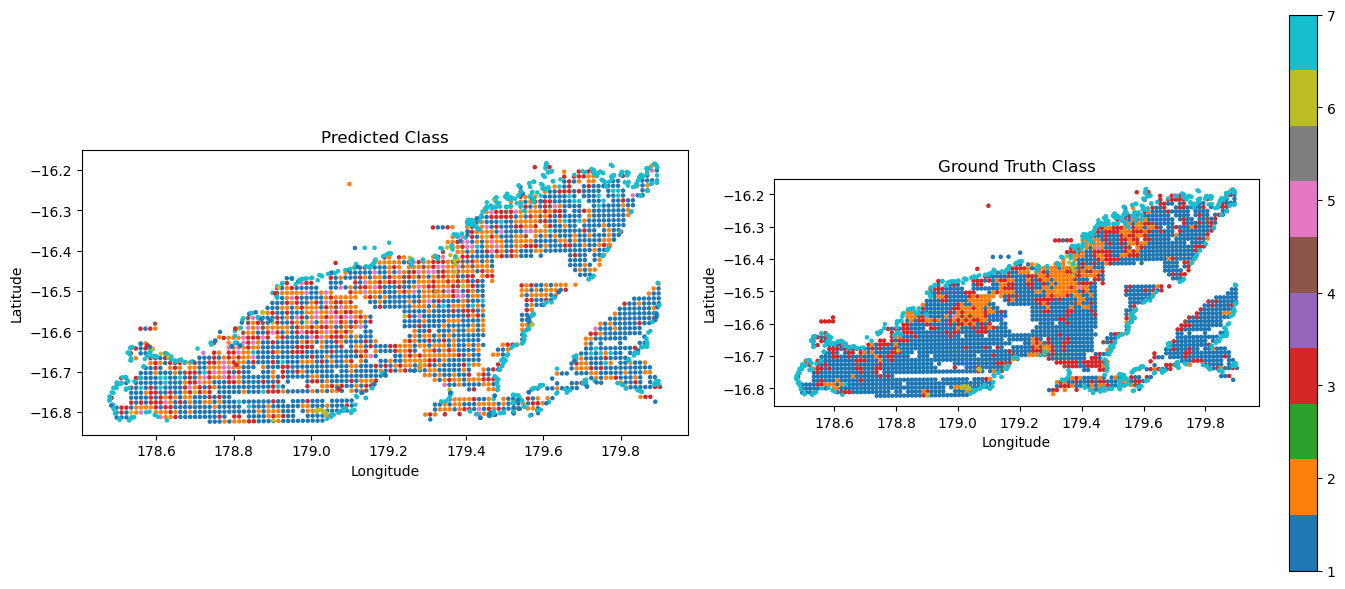

In [82]:
# Plot prediction and groundtruth 
geometry = [Point(xy) for xy in zip(fiji_test['lon'], fiji_test['lat'])]
gdf = gpd.GeoDataFrame(fiji_test, geometry=geometry, crs='EPSG:4326')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


gdf.plot(column='predicted_class', cmap='tab10', legend=False,
         ax=axes[0], markersize=5)
axes[0].set_title("Predicted Class")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
gdf.plot(column='class_id', cmap='tab10', legend=True,
         ax=axes[1], markersize=5)
axes[1].set_title("Ground Truth Class")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()


## 4. Comparison with Fractional Cover k-means clustering 

In [120]:
with rasterio.open('bs_pc_50_test.tif') as src:
    bs = src.read(1).astype('float32')
    meta = src.meta

with rasterio.open('pv_pc_50_test.tif') as src:
    pv = src.read(1).astype('float32')

with rasterio.open('npv_pc_50_test.tif') as src:
    npv = src.read(1).astype('float32')

def normalize_band(band, scale=255):
    return np.clip(band / scale, 0, 1)

bs_norm = normalize_band(bs, 255)
pv_norm = normalize_band(pv, 255)
npv_norm = normalize_band(npv, 255)

#  Stack into RGB 
rgb = np.dstack((bs_norm, pv_norm, npv_norm))
rgb = np.clip(rgb, 0, 1)


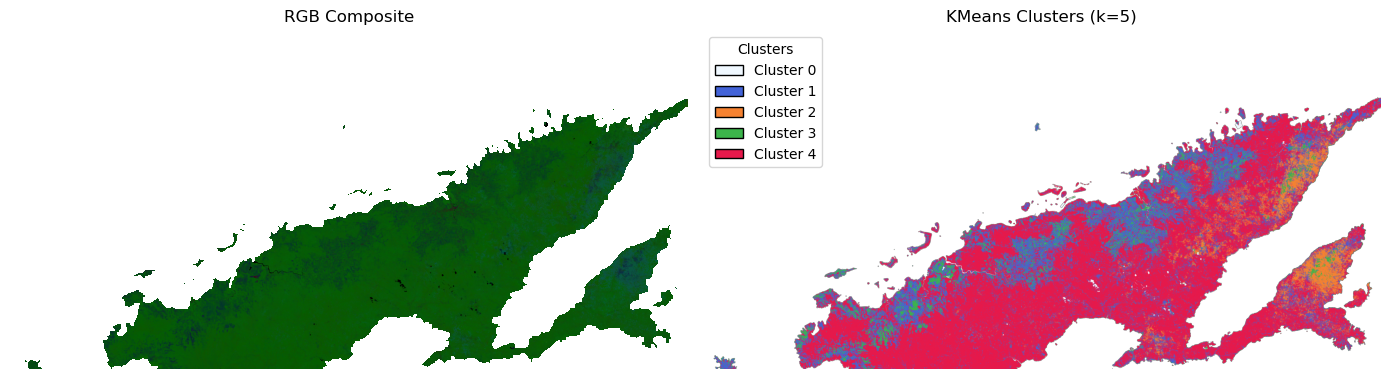

In [121]:
k = 5
h, w, c = rgb.shape

# Prepare Data for Clustering 
flat_rgb = rgb.reshape(-1, 3)
valid_mask = ~np.isnan(flat_rgb).any(axis=1)
rgb_valid = flat_rgb[valid_mask]

# KMeans Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels = np.full(flat_rgb.shape[0], np.nan)
labels[valid_mask] = kmeans.fit_predict(rgb_valid)
label_img = labels.reshape(h, w)

# Plot RGB and Cluster Image 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(rgb)
axes[0].set_title("RGB Composite")
axes[0].axis('off')

fixed_colors = [
    'aliceblue', '#4363d8', '#f58231', '#3cb44b', '#e6194b',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe'
]
cluster_cmap = ListedColormap(fixed_colors[:k])

axes[1].imshow(label_img, cmap=cluster_cmap)
axes[1].set_title(f'KMeans Clusters (k={k})')
axes[1].axis('off')

legend_elements = [
    Patch(facecolor=cluster_cmap(i), edgecolor='black', label=f'Cluster {i}')
    for i in range(k)
]
axes[1].legend(handles=legend_elements, loc='upper left', title='Clusters')
plt.tight_layout()
plt.show()
